In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from keras.preprocessing.image import array_to_img
%matplotlib inline

# Download SVHN Dataset

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')
extra_filename = maybe_download('extra.tar.gz')

Attempting to download: train.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Attempting to download: test.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Attempting to download: extra.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!


# Unpack Dataset

In [3]:
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = root
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
extra_folders = maybe_extract(extra_filename)

Extracting data for train. This may take a while. Please wait.
train
Extracting data for test. This may take a while. Please wait.
test
Extracting data for extra. This may take a while. Please wait.
extra


# Load Labels and BBox
Load dataset labels from matlab file format into python dict.

For the image:
![](test/2.png)

The python dict format looks like:
```python
{'boxes': [
                {'height': 23.0,'label': 2.0, 'left': 99.0, 'top': 5.0, 'width': 14.0},
                {'height': 23.0, 'label': 1.0, 'left': 114.0, 'top': 8.0, 'width': 8.0},
                {'height': 23.0, 'label': 10.0, 'left': 121.0, 'top': 6.0, 'width': 12.0}
          ],
 'filename': '2.png'}
```

In [4]:
import h5py

class DigitStructFile:
    """
     The DigitStructFile is just a wrapper around the h5py data.  
     It basically references:
         inf:              The input h5 matlab file
             digitStructName   The h5 ref to all the file names
             digitStructBbox   The h5 ref to all struc data
    """
    
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def getName(self,n):
        """getName returns the 'name' string for for the n(th) digitStruct. """
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])
 
    def bboxHelper(self,attr):
        """bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox."""
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def getBbox(self,n):
        """getBbox returns a dict of data for the n(th) bbox. """
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s


    def getAllDigitStructure(self):
        """ returns all the digitStruct from the input file """
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]


    def getAllDigitStructure_ByDigit(self):
        """Return a restructured version of the dataset (one structure by boxed digit).

        Return a list of such dicts :
             'filename' : filename of the samples
             'boxes' : list of such dicts (one by digit) :
                 'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
                 'left', 'top' : position of bounding box
                 'width', 'height' : dimension of bounding box

        Note: We may turn this to a generator, if memory issues arise."""
        
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [5]:
train_folders = 'train'
test_folders = 'test'
extra_folders = 'extra'

In [6]:
fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

In [8]:
test_data[1]

NameError: name 'test_data' is not defined

In [9]:
fin = os.path.join(test_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()

KeyboardInterrupt: 

In [7]:
fin = os.path.join(extra_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
extra_data = dsf.getAllDigitStructure_ByDigit()

# Check Image Size

In [10]:
from PIL import Image
train_imsize = np.ndarray([len(train_data),2])
for i in np.arange(len(train_data)):
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    im = Image.open(fullname)
    train_imsize[i, :] = im.size[:]

In [11]:
print(np.amax(train_imsize[:,0]), np.amax(train_imsize[:,1]))
print(np.amin(train_imsize[:,0]), np.amin(train_imsize[:,1]))

876.0 501.0
25.0 12.0


In [10]:
test_imsize = np.ndarray([len(test_data),2])
for i in np.arange(len(test_data)):
    filename = test_data[i]['filename']
    fullname = os.path.join(test_folders, filename)
    im = Image.open(fullname)
    test_imsize[i, :] = im.size[:]

print(np.amax(test_imsize[:,0]), np.amax(test_imsize[:,1]))
print(np.amin(test_imsize[:,0]), np.amin(test_imsize[:,1]))

1083.0 516.0
31.0 13.0


In [11]:
extra_imsize = np.ndarray([len(extra_data),2])
for i in np.arange(len(extra_data)):
    filename = extra_data[i]['filename']
    fullname = os.path.join(extra_folders, filename)
    im = Image.open(fullname)
    extra_imsize[i, :] = im.size[:]

print(np.amax(extra_imsize[:,0]), np.amax(extra_imsize[:,1]))
print(np.amin(extra_imsize[:,0]), np.amin(extra_imsize[:,1]))

668.0 415.0
22.0 13.0


In [12]:
print(np.where(train_imsize[:,0]==876))
print(np.where(train_imsize[:,0]==25))
print(np.where(test_imsize[:,0]==1083))
print(np.where(test_imsize[:,0]==31))
print(np.where(extra_imsize[:,0]==668))
print(np.where(extra_imsize[:,0]==22))

(array([  410,  4163, 15855, 30484]),)
(array([9747]),)
(array([ 1722,  2949,  6233, 12862]),)
(array([  459,  5352,  7776, 11257, 12191]),)
(array([ 32352,  78946, 104221, 191787, 198954]),)
(array([ 19731,  25534,  56510, 110583, 127903, 165055, 183311, 184799,
       193713, 195221]),)


# Prepare Dataset

In [12]:
import PIL.Image as Image

def generate_dataset(data, folder):
    """prepare dataset
    INPUT:
        data: python dict formated data
        folder: folder path of image file
    OUTPUT: 
        dataset: numeric image
        labels: [digits_len, 1st_digit, 2nd_digit, 3rd_digit, 4th_digit, 5th_digit]
        where digit is 0-9, and blank is 10
    """

    dataset = np.ndarray([len(data),32,32,1], dtype='float32')
    labels = np.ones([len(data),6], dtype=int) * 10
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        labels[i,0] = num_digit
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):
            if j < 5: # if fewer than 5 digits, 0-9 represents digits, 10 represents blank
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10: labels[i,j+1] = 0
            else: print('#',i,'image has more than 5 digits.')
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left
        
        im_top = np.floor(im_top - 0.1 * im_height)
        im_left = np.floor(im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])

        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.ANTIALIAS)
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        im = (im - mean) / std
        dataset[i,:,:,:] = im[:,:,:]

    return dataset, labels

In [14]:
train_dataset, train_labels = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape)

# 29929 image has more than 5 digits.
(33402, 32, 32, 1) (33402, 6)


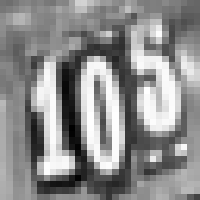

In [30]:
im = array_to_img(np.expand_dims(train_dataset[201].reshape([32,32]), axis=2))
im.resize((200,200))

In [ ]:
train_dataset, train_labels = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape)

test_dataset, test_labels = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)

extra_dataset, extra_labels = generate_dataset(extra_data, extra_folders)
print(extra_dataset.shape, extra_labels.shape)

## Delete the image that contains more than 5 digits

In [27]:
train_data[29929]

{'boxes': [{'height': 18.0,
   'label': 1.0,
   'left': 18.0,
   'top': 3.0,
   'width': 5.0},
  {'height': 18.0, 'label': 3.0, 'left': 24.0, 'top': 3.0, 'width': 6.0},
  {'height': 18.0, 'label': 5.0, 'left': 30.0, 'top': 4.0, 'width': 8.0},
  {'height': 18.0, 'label': 4.0, 'left': 37.0, 'top': 3.0, 'width': 10.0},
  {'height': 18.0, 'label': 5.0, 'left': 48.0, 'top': 4.0, 'width': 9.0},
  {'height': 18.0, 'label': 8.0, 'left': 56.0, 'top': 4.0, 'width': 8.0}],
 'filename': '29930.png'}

![](train/29930.png)

In [14]:
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

In [15]:
print(train_dataset.shape, train_labels.shape)

(33401, 32, 32, 1) (33401, 6)


## Randomize Train/Validation set split

In [16]:
import random

random.seed()

n_labels = 10
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []
for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,1] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,1] == (i))[0][400:].tolist())
    valid_index2.extend(np.where(extra_labels[:,1] == (i))[0][:200].tolist())
    train_index2.extend(np.where(extra_labels[:,1] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

valid_dataset = np.concatenate((extra_dataset[valid_index2,:,:,:], train_dataset[valid_index,:,:,:]), axis=0)
valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)
train_dataset_t = np.concatenate((extra_dataset[train_index2,:,:,:], train_dataset[train_index,:,:,:]), axis=0)
train_labels_t = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)

print(train_dataset_t.shape, train_labels_t.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(230070, 32, 32, 1) (230070, 6)
(13068, 32, 32, 1) (13068, 6)
(5684, 32, 32, 1) (5684, 6)


# Pickle Prepared Dataset

In [17]:
pickle_file = 'SVHN_multi.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_t,
    'train_labels': train_labels_t,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1031118898
